<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporaisLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 27.5 MB/s 
     |████████████████████████████████| 9.8 MB 50.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-05-23 23:05:29--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 352.02K  --.-KB/s    in 0.004s  

2022-05-23 23:05:29 (88.0 MB/s) - ‘train.csv’ saved [360467/360467]

--2022-05-23 23:05:29--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: ‘tes

In [ ]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [5]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
df_treino= df_treino.reindex(idx)
df_treino.fillna(method='ffill', inplace=True)

In [6]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 11:45:00', freq='15T'),
 Timestamp('2012-04-11 06:30:00', freq='15T'))

In [7]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2012-03-13 11:45:00 to 2012-04-11 06:30:00
Freq: 15T
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   Date                              2764 non-null   object 
 2   Time                              2764 non-null   object 
 3   CO2_(dinning-room)                2764 non-null   float64
 4   CO2_room                          2764 non-null   float64
 5   Relative_humidity_(dinning-room)  2764 non-null   float64
 6   Relative_humidity_room            2764 non-null   float64
 7   Lighting_(dinning-room)           2764 non-null   float64
 8   Lighting_room                     2764 non-null   float64
 9   Meteo_Rain                        2764 non-null   float64
 10  Meteo_Sun_dusk                    2764 non-null   float64
 11  Meteo_Wind             

In [8]:
df_treino.groupby('Date')['Id'].count().reset_index().sort_values('Date')

,Date,Id
0,01/04/2012,96
1,02/04/2012,96
2,03/04/2012,96
3,04/04/2012,96
4,05/04/2012,96
5,06/04/2012,96
6,07/04/2012,96
7,08/04/2012,96
8,09/04/2012,96
9,10/04/2012,96


In [9]:
df_treino = df_treino[df_treino['Date']!="13/03/2012"]
df_treino = df_treino[df_treino['Date']!="11/04/2012"]

In [10]:
df_treino.head(3)

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
2012-03-14 00:00:00,49,14/03/2012,00:00,217.835,223.381,41.4320,43.1573,11.6053,13.0207,0.0,0.650,0.0,0.0,0.0,0.0,-3.25067,57.5627,2.06667,19.5260
2012-03-14 00:15:00,50,14/03/2012,00:15,219.115,223.637,41.0427,43.1600,11.6053,13.5413,0.0,0.650,0.0,0.0,0.0,0.0,-3.31600,57.4720,3.00000,19.3733
2012-03-14 00:30:00,51,14/03/2012,00:30,219.200,225.131,41.0133,43.1520,11.5240,13.1027,0.0,0.738,0.0,0.0,0.0,0.0,-3.44667,57.7253,3.00000,19.2087


In [11]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(2400, 19) (288, 19)
2012-03-14 00:00:00 2012-04-07 23:45:00
2012-04-08 00:00:00 2012-04-10 23:45:00


(array([ 82.,  75., 153., 246., 354., 512., 447., 314., 172.,  45.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

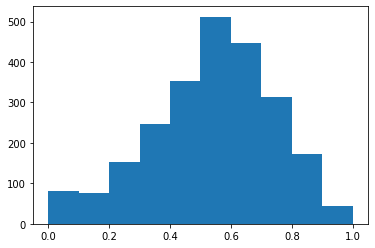

In [12]:
#padronizando os valores de 'confirmed' para o dataset de treino e teste - colocando todos os exemplos na mesma escala
scaler = MinMaxScaler()
scaler.fit(dfTreino[['Indoor_temperature_room']])

scaled_train = scaler.transform(dfTreino[['Indoor_temperature_room']])
scaled_test = scaler.transform(dfTeste[['Indoor_temperature_room']])

plt.hist(scaled_train)


In [13]:
# gerando as entradas para a rede neural - (o gerador)

n_input = 96
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)
len(generator)

1152

In [14]:
#definindo o modelo e imprimindo a arquitetura
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse' )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=200)

Epoch 1/200
1152/1152 [==============================] - 33s 27ms/step - loss: 0.0090
Epoch 2/200
1152/1152 [==============================] - 32s 28ms/step - loss: 3.6919e-04
Epoch 3/200
1152/1152 [==============================] - 32s 28ms/step - loss: 1.8279e-04
Epoch 4/200
1152/1152 [==============================] - 34s 30ms/step - loss: 2.1128e-04
Epoch 5/200
1152/1152 [==============================] - 34s 30ms/step - loss: 1.2191e-04
Epoch 6/200
1152/1152 [==============================] - 33s 29ms/step - loss: 1.0944e-04
Epoch 7/200
1152/1152 [==============================] - 32s 28ms/step - loss: 1.1238e-04
Epoch 8/200
1152/1152 [==============================] - 33s 29ms/step - loss: 8.0494e-05
Epoch 9/200
1152/1152 [==============================] - 31s 27ms/step - loss: 7.5951e-05
Epoch 10/200
1152/1152 [==============================] - 31s 27ms/step - loss: 6.2237e-05
Epoch 11/200
1152/1152 [==============================] - 40s 35ms/step - loss: 7.0934e-05
Epoch 12/200

In [ ]:
#verificando a descida do grandiente com a função loss = mse
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(scaled_test.shape[0]):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
dfTeste['LSTM'] = true_predictions
plotaSeries(dfTreino['confirmed'], dfTeste['confirmed'], dfTeste['LSTM'])